## Setup

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from tensorflow.keras import layers

keras = tf.keras

In [0]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
  

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
# Loading Data
import pandas as pd
#!ls /content/drive/'My Drive'/'Colab Notebooks'
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Term_project_simulation/selected_data_ISONE.csv')
data.head()

date  year  month  day  weekday  hour   demand  temperature
0  2003/3/1  2003      3    1        7     1  12863.0           23
1  2003/3/1  2003      3    1        7     2  12389.0           22
2  2003/3/1  2003      3    1        7     3  12155.0           21
3  2003/3/1  2003      3    1        7     4  12072.0           21
4  2003/3/1  2003      3    1        7     5  12160.0           22

In [7]:
data['load'] = data['demand']/data['demand'].values.max()
data.head()

date  year  month  day  weekday  hour   demand  temperature      load
0  2003/3/1  2003      3    1        7     1  12863.0           23  0.465680
1  2003/3/1  2003      3    1        7     2  12389.0           22  0.448519
2  2003/3/1  2003      3    1        7     3  12155.0           21  0.440048
3  2003/3/1  2003      3    1        7     4  12072.0           21  0.437043
4  2003/3/1  2003      3    1        7     5  12160.0           22  0.440229

In [8]:
data = data.set_index("date")
data.head()

year  month  day  weekday  hour   demand  temperature      load
date                                                                     
2003/3/1  2003      3    1        7     1  12863.0           23  0.465680
2003/3/1  2003      3    1        7     2  12389.0           22  0.448519
2003/3/1  2003      3    1        7     3  12155.0           21  0.440048
2003/3/1  2003      3    1        7     4  12072.0           21  0.437043
2003/3/1  2003      3    1        7     5  12160.0           22  0.440229

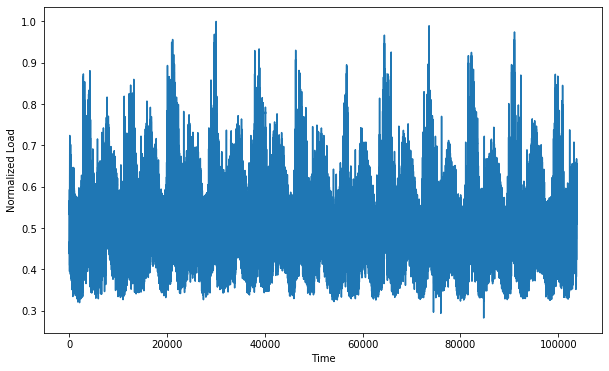

In [9]:
actual_data = data['load'].values
actual_data.shape
t = np.arange(len(actual_data))

plt.figure(figsize=(10,6))
# summarize history for accuracy
plt.plot(t,actual_data)
#plt.title('model accuracy')
plt.ylabel('Normalized Load')
plt.xlabel('Time')
plt.show()

In [10]:
series = data.loc[:'2006/12/31']
series.head()

year  month  day  weekday  hour   demand  temperature      load
date                                                                     
2003/3/1  2003      3    1        7     1  12863.0           23  0.465680
2003/3/1  2003      3    1        7     2  12389.0           22  0.448519
2003/3/1  2003      3    1        7     3  12155.0           21  0.440048
2003/3/1  2003      3    1        7     4  12072.0           21  0.437043
2003/3/1  2003      3    1        7     5  12160.0           22  0.440229

In [11]:
series.tail()

year  month  day  weekday  hour   demand  temperature      load
date                                                                       
2006/12/31  2006     12   31        1    20  16400.0           30  0.593730
2006/12/31  2006     12   31        1    21  15742.0           31  0.569908
2006/12/31  2006     12   31        1    22  15020.0           30  0.543769
2006/12/31  2006     12   31        1    23  14233.0           29  0.515278
2006/12/31  2006     12   31        1    24  13442.0           29  0.486641

In [12]:
train_series = series.loc[:'2005/12/31']
train_series.tail()

year  month  day  weekday  hour   demand  temperature      load
date                                                                       
2005/12/31  2005     12   31        7    20  17052.0           26  0.617334
2005/12/31  2005     12   31        7    21  16334.0           29  0.591340
2005/12/31  2005     12   31        7    22  15564.0           29  0.563464
2005/12/31  2005     12   31        7    23  14804.0           29  0.535950
2005/12/31  2005     12   31        7    24  14000.0           29  0.506842

In [13]:
valid_series = series.loc['2006/1/1':]
valid_series.tail(2)

year  month  day  weekday  hour   demand  temperature      load
date                                                                       
2006/12/31  2006     12   31        1    23  14233.0           29  0.515278
2006/12/31  2006     12   31        1    24  13442.0           29  0.486641

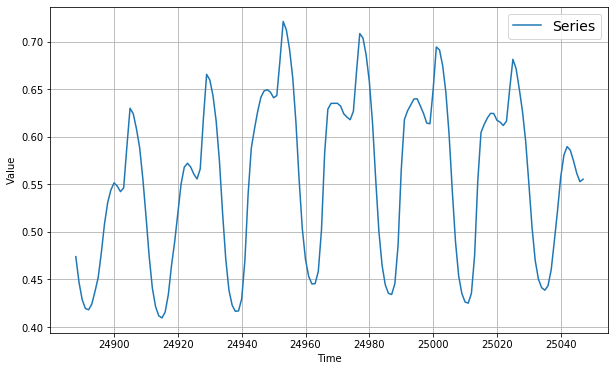

In [14]:
# Entire Series
split_time = len(train_series)
Series = series['load'].values
time = np.arange(len(series))

x_train = Series[:split_time]
x_valid = Series[split_time:]

time_valid = time[split_time:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid,start =0, end=160, label="Series")
window_size = 24

# Fully Convolutional Forecasting 32

In [0]:
import time
start = time.time()
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 24
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )

model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(lr=1e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mape"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

end = time.time()

print("Time elasped in minutes", (end-start)/60)

Epoch 1/100
195/195 [==============================] - 8s 39ms/step - loss: 0.0796 - mape: 66.0377
Epoch 2/100
195/195 [==============================] - 3s 15ms/step - loss: 0.0050 - mape: 14.9691
Epoch 3/100
195/195 [==============================] - 3s 15ms/step - loss: 0.0022 - mape: 10.2868
Epoch 4/100
195/195 [==============================] - 3s 15ms/step - loss: 0.0014 - mape: 8.0880
Epoch 5/100
195/195 [==============================] - 3s 14ms/step - loss: 8.5915e-04 - mape: 6.2921
Epoch 6/100
195/195 [==============================] - 3s 15ms/step - loss: 5.6325e-04 - mape: 4.9876
Epoch 7/100
195/195 [==============================] - 3s 15ms/step - loss: 4.0146e-04 - mape: 4.1051
Epoch 8/100
195/195 [==============================] - 3s 15ms/step - loss: 3.1736e-04 - mape: 3.5607
Epoch 9/100
195/195 [==============================] - 3s 15ms/step - loss: 2.6781e-04 - mape: 3.2037
Epoch 10/100
195/195 [==============================] - 3s 15ms/step - loss: 2.3574e-04 - mape:

[0.0001, 0.1, 0, 0.1]

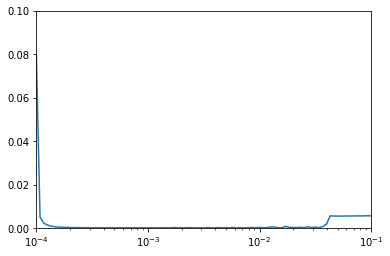

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 0.1])

In [0]:
import time
start = time.time()
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 24
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )


model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = keras.optimizers.Adam(lr=3e-3)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mape"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])
end = time.time()
print("Time elasped in minutes", (end-start)/60)

Epoch 1/500
195/195 [==============================] - 9s 46ms/step - loss: 0.0050 - mape: 11.0153 - val_loss: 0.0000e+00 - val_mape: 0.0000e+00
Epoch 2/500
195/195 [==============================] - 4s 20ms/step - loss: 1.8027e-04 - mape: 2.4248 - val_loss: 1.4804e-04 - val_mape: 2.1584
Epoch 3/500
195/195 [==============================] - 4s 19ms/step - loss: 1.4192e-04 - mape: 2.0983 - val_loss: 1.3241e-04 - val_mape: 2.0647
Epoch 4/500
195/195 [==============================] - 4s 20ms/step - loss: 1.6217e-04 - mape: 2.2854 - val_loss: 1.7827e-04 - val_mape: 2.3725
Epoch 5/500
195/195 [==============================] - 4s 21ms/step - loss: 1.2387e-04 - mape: 1.8553 - val_loss: 1.1977e-04 - val_mape: 1.8303
Epoch 6/500
195/195 [==============================] - 4s 21ms/step - loss: 1.1097e-04 - mape: 1.7394 - val_loss: 1.2206e-04 - val_mape: 1.9907
Epoch 7/500
195/195 [==============================] - 4s 20ms/step - loss: 1.0813e-04 - mape: 1.7105 - val_loss: 1.1974e-04 - val_mape

In [0]:
model = keras.models.load_model("my_checkpoint.h5")

export_path_keras = "/{}.h5".format("content/drive/My Drive/Colab Notebooks/Term_project_simulation/wavenet_32_new_2")
print(export_path_keras)
model.save(export_path_keras)

/content/drive/My Drive/Colab Notebooks/Term_project_simulation/wavenet_32_new_2.h5


In [0]:
history.history.keys()

dict_keys(['loss', 'mape', 'val_loss', 'val_mape'])

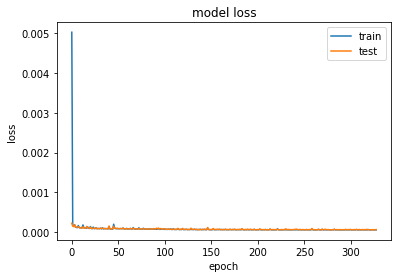

In [0]:
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
#plt.axis([0, 300, 0, 0.002])
plt.show()

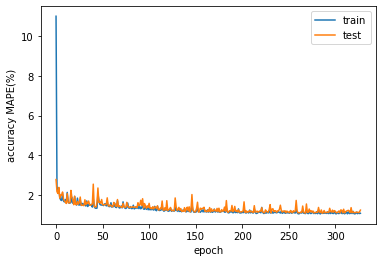

In [0]:
# summarize history for loss
plt.plot(history.history['mape'])
plt.plot(history.history['val_mape'])
#plt.title('model accuracy')
plt.ylabel('accuracy MAPE(%)')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


In [0]:
cnn_forecast = model_forecast(model, Series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

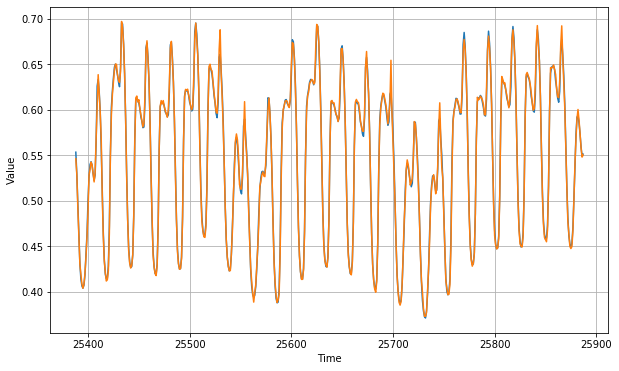

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=500, end = 1000)
plot_series(time_valid, cnn_forecast,start=500, end = 1000)

In [0]:
keras.metrics.mean_absolute_percentage_error(x_valid, cnn_forecast).numpy()

0.7862957

## Fully Convolutional Forecasting

In [0]:
import time
start = time.time()
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 24
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32, 64):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )

for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(lr=1e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mape"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

end = time.time()

print("Time elasped in minutes", (end-start)/60)

Epoch 1/100
195/195 [==============================] - 6s 33ms/step - loss: 0.0740 - mape: 61.8989
Epoch 2/100
195/195 [==============================] - 4s 19ms/step - loss: 0.0079 - mape: 18.7447
Epoch 3/100
195/195 [==============================] - 3s 18ms/step - loss: 0.0040 - mape: 13.9515
Epoch 4/100
195/195 [==============================] - 4s 18ms/step - loss: 0.0018 - mape: 9.2150
Epoch 5/100
195/195 [==============================] - 4s 18ms/step - loss: 6.4815e-04 - mape: 5.2140
Epoch 6/100
195/195 [==============================] - 3s 17ms/step - loss: 3.0134e-04 - mape: 3.3402
Epoch 7/100
195/195 [==============================] - 3s 18ms/step - loss: 2.0380e-04 - mape: 2.6890
Epoch 8/100
195/195 [==============================] - 3s 18ms/step - loss: 1.6573e-04 - mape: 2.3725
Epoch 9/100
195/195 [==============================] - 3s 17ms/step - loss: 1.4802e-04 - mape: 2.1857
Epoch 10/100
195/195 [==============================] - 4s 19ms/step - loss: 1.3758e-04 - mape:

[0.0001, 0.1, 0, 0.1]

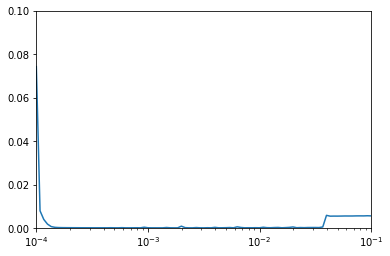

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 0.1])

In [0]:
start = time.time()
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 24
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32, 64):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )


model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = keras.optimizers.Adam(lr=1e-3)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mape"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])
end = time.time()
print("Time elasped in minutes", (end-start)/60)

Epoch 1/500
195/195 [==============================] - 6s 31ms/step - loss: 0.0151 - mape: 22.5231 - val_loss: 0.0000e+00 - val_mape: 0.0000e+00
Epoch 2/500
195/195 [==============================] - 4s 20ms/step - loss: 6.1584e-04 - mape: 4.5687 - val_loss: 2.5508e-04 - val_mape: 3.1733
Epoch 3/500
195/195 [==============================] - 4s 21ms/step - loss: 2.0455e-04 - mape: 2.6539 - val_loss: 1.6141e-04 - val_mape: 2.3601
Epoch 4/500
195/195 [==============================] - 4s 22ms/step - loss: 1.4078e-04 - mape: 2.0753 - val_loss: 1.2894e-04 - val_mape: 1.9916
Epoch 5/500
195/195 [==============================] - 4s 21ms/step - loss: 1.1943e-04 - mape: 1.8319 - val_loss: 1.1627e-04 - val_mape: 1.8242
Epoch 6/500
195/195 [==============================] - 4s 20ms/step - loss: 1.1038e-04 - mape: 1.7309 - val_loss: 1.1195e-04 - val_mape: 1.7905
Epoch 7/500
195/195 [==============================] - 4s 20ms/step - loss: 1.0600e-04 - mape: 1.6900 - val_loss: 1.0742e-04 - val_mape

In [0]:
model = keras.models.load_model("my_checkpoint.h5")

export_path_keras = "/{}.h5".format("content/drive/My Drive/Colab Notebooks/Term_project_simulation/wavenet_64_new")
print(export_path_keras)
model.save(export_path_keras)

/content/drive/My Drive/Colab Notebooks/Term_project_simulation/wavenet_64_new.h5


In [0]:
cnn_forecast = model_forecast(model, Series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

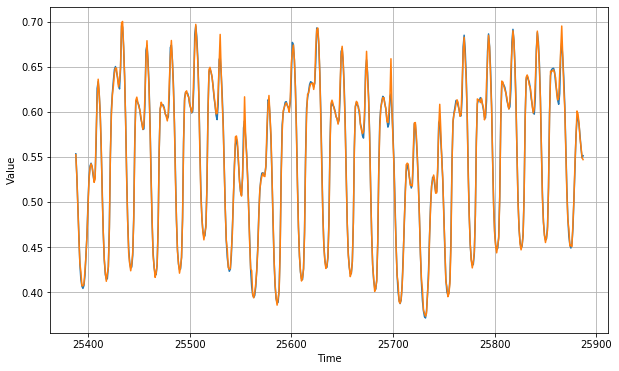

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=500, end = 1000)
plot_series(time_valid, cnn_forecast,start=500, end = 1000)

In [0]:
keras.metrics.mean_absolute_percentage_error(x_valid, cnn_forecast).numpy()

0.7718608

## Fully Convolutional Forecasting 128

In [0]:
import time
start = time.time()
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 24
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32, 64, 128):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )


model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(lr=1e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mape"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

end = time.time()

print("Time elasped in minutes", (end-start)/60)

Epoch 1/100
195/195 [==============================] - 5s 28ms/step - loss: 0.0891 - mape: 71.4327
Epoch 2/100
195/195 [==============================] - 3s 15ms/step - loss: 0.0051 - mape: 15.5078
Epoch 3/100
195/195 [==============================] - 3s 16ms/step - loss: 0.0028 - mape: 11.7883
Epoch 4/100
195/195 [==============================] - 3s 17ms/step - loss: 0.0020 - mape: 9.9790
Epoch 5/100
195/195 [==============================] - 3s 16ms/step - loss: 0.0013 - mape: 7.8635
Epoch 6/100
195/195 [==============================] - 3s 16ms/step - loss: 7.4315e-04 - mape: 5.9232
Epoch 7/100
195/195 [==============================] - 3s 17ms/step - loss: 4.1022e-04 - mape: 4.2718
Epoch 8/100
195/195 [==============================] - 3s 16ms/step - loss: 2.8703e-04 - mape: 3.4254
Epoch 9/100
195/195 [==============================] - 3s 15ms/step - loss: 2.2996e-04 - mape: 2.9598
Epoch 10/100
195/195 [==============================] - 3s 16ms/step - loss: 2.0210e-04 - mape: 2.7

[0.0001, 0.1, 0, 0.1]

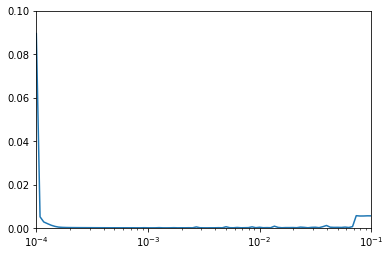

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 0.1])

In [0]:
start = time.time()
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 24
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32, 64, 128):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )


model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = keras.optimizers.Adam(lr=2e-3)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mape"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])
end = time.time()
print("Time elasped in minutes", (end-start)/60)

Epoch 1/500
195/195 [==============================] - 7s 36ms/step - loss: 0.0080 - mape: 15.1986 - val_loss: 0.0000e+00 - val_mape: 0.0000e+00
Epoch 2/500
195/195 [==============================] - 4s 20ms/step - loss: 2.6532e-04 - mape: 3.0178 - val_loss: 1.9369e-04 - val_mape: 2.5747
Epoch 3/500
195/195 [==============================] - 4s 21ms/step - loss: 1.6623e-04 - mape: 2.2738 - val_loss: 1.4881e-04 - val_mape: 2.1870
Epoch 4/500
195/195 [==============================] - 4s 21ms/step - loss: 1.3545e-04 - mape: 1.9853 - val_loss: 1.3448e-04 - val_mape: 2.0163
Epoch 5/500
195/195 [==============================] - 4s 22ms/step - loss: 1.3504e-04 - mape: 2.0294 - val_loss: 1.2466e-04 - val_mape: 2.0204
Epoch 6/500
195/195 [==============================] - 4s 21ms/step - loss: 1.1247e-04 - mape: 1.7332 - val_loss: 1.2752e-04 - val_mape: 2.0505
Epoch 7/500
195/195 [==============================] - 4s 22ms/step - loss: 1.0918e-04 - mape: 1.7127 - val_loss: 1.1544e-04 - val_mape

In [0]:
model = keras.models.load_model("my_checkpoint.h5")

export_path_keras = "/{}.h5".format("content/drive/My Drive/Colab Notebooks/Term_project_simulation/wavenet_128_new")
print(export_path_keras)
model.save(export_path_keras)

/content/drive/My Drive/Colab Notebooks/Term_project_simulation/wavenet_128_new.h5


In [0]:
cnn_forecast = model_forecast(model, Series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

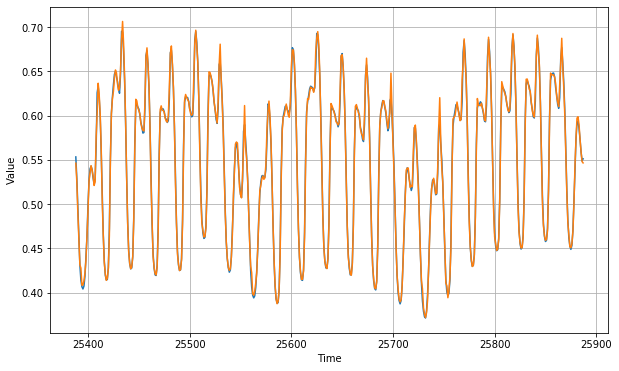

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=500, end = 1000)
plot_series(time_valid, cnn_forecast,start=500, end = 1000)

In [0]:
keras.metrics.mean_absolute_percentage_error(x_valid, cnn_forecast).numpy()

0.67494327

## Fully Convolutional Forecasting 256

In [0]:
import time
start = time.time()
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 24
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32, 64, 128,256):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )


model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(lr=1e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mape"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

end = time.time()

print("Time elasped in minutes", (end-start)/60)

Epoch 1/100
195/195 [==============================] - 12s 62ms/step - loss: 0.0736 - mape: 61.9343
Epoch 2/100
195/195 [==============================] - 6s 29ms/step - loss: 0.0051 - mape: 15.4712
Epoch 3/100
195/195 [==============================] - 6s 28ms/step - loss: 0.0028 - mape: 11.9137
Epoch 4/100
195/195 [==============================] - 6s 29ms/step - loss: 0.0019 - mape: 9.6295
Epoch 5/100
195/195 [==============================] - 6s 28ms/step - loss: 0.0011 - mape: 7.1621
Epoch 6/100
195/195 [==============================] - 6s 29ms/step - loss: 5.9024e-04 - mape: 5.0354
Epoch 7/100
195/195 [==============================] - 6s 29ms/step - loss: 3.8523e-04 - mape: 3.9245
Epoch 8/100
195/195 [==============================] - 6s 29ms/step - loss: 2.9476e-04 - mape: 3.3477
Epoch 9/100
195/195 [==============================] - 5s 27ms/step - loss: 2.4180e-04 - mape: 2.9808
Epoch 10/100
195/195 [==============================] - 6s 30ms/step - loss: 2.0929e-04 - mape: 2.

[0.0001, 0.1, 0, 0.1]

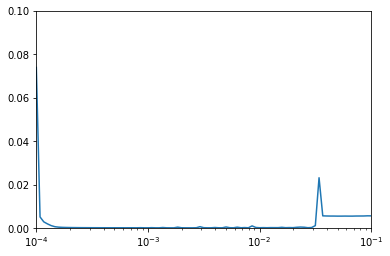

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 0.1])

In [0]:
start = time.time()
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 24
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32, 64, 128, 256):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )


model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = keras.optimizers.Adam(lr=2e-3)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mape"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])
end = time.time()
print("Time elasped in minutes", (end-start)/60)

Epoch 1/500
195/195 [==============================] - 10s 53ms/step - loss: 0.0091 - mape: 16.5972 - val_loss: 0.0000e+00 - val_mape: 0.0000e+00
Epoch 2/500
195/195 [==============================] - 7s 37ms/step - loss: 2.6703e-04 - mape: 3.0551 - val_loss: 1.8597e-04 - val_mape: 2.6189
Epoch 3/500
195/195 [==============================] - 7s 38ms/step - loss: 1.6319e-04 - mape: 2.3305 - val_loss: 1.4264e-04 - val_mape: 2.1918
Epoch 4/500
195/195 [==============================] - 7s 37ms/step - loss: 1.4015e-04 - mape: 2.1221 - val_loss: 1.2706e-04 - val_mape: 1.9614
Epoch 5/500
195/195 [==============================] - 7s 37ms/step - loss: 1.1957e-04 - mape: 1.8440 - val_loss: 1.1796e-04 - val_mape: 1.7864
Epoch 6/500
195/195 [==============================] - 7s 37ms/step - loss: 1.3117e-04 - mape: 1.9903 - val_loss: 1.7919e-04 - val_mape: 2.8045
Epoch 7/500
195/195 [==============================] - 7s 37ms/step - loss: 1.1804e-04 - mape: 1.8193 - val_loss: 1.1768e-04 - val_map

In [0]:
model = keras.models.load_model("my_checkpoint.h5")

export_path_keras = "/{}.h5".format("content/drive/My Drive/Colab Notebooks/Term_project_simulation/wavenet_256_new")
print(export_path_keras)
model.save(export_path_keras)

/content/drive/My Drive/Colab Notebooks/Term_project_simulation/wavenet_256_new.h5


In [0]:
cnn_forecast = model_forecast(model, Series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

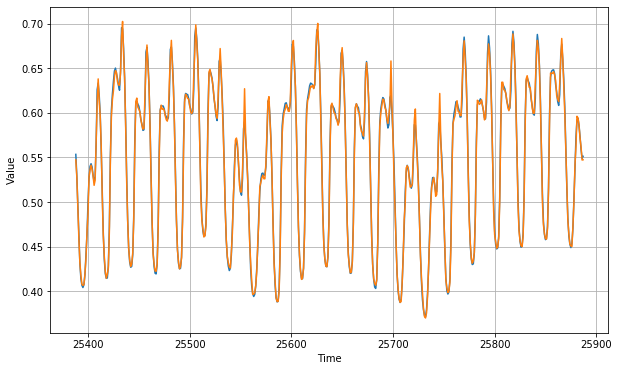

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=500, end = 1000)
plot_series(time_valid, cnn_forecast,start=500, end = 1000)

In [0]:
keras.metrics.mean_absolute_percentage_error(x_valid, cnn_forecast).numpy()

0.8414944

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          96        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 32)          2

# Testing for 12 Months


In [15]:
# Wavenet 128
export_path_sm = "/{}.h5".format("content/drive/My Drive/Colab Notebooks/Term_project_simulation/wavenet_128_new")
wavenet_128 = tf.keras.models.load_model(
  export_path_sm,
  custom_objects={'KerasLayer': hub.KerasLayer})

model = wavenet_128 
wavenet_128.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          96        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 32)          2

In [0]:
cnn_forecast = model_forecast(model, Series[..., np.newaxis], window_size)
cnn_forecast_128 = cnn_forecast[split_time - window_size:-1, -1, 0]

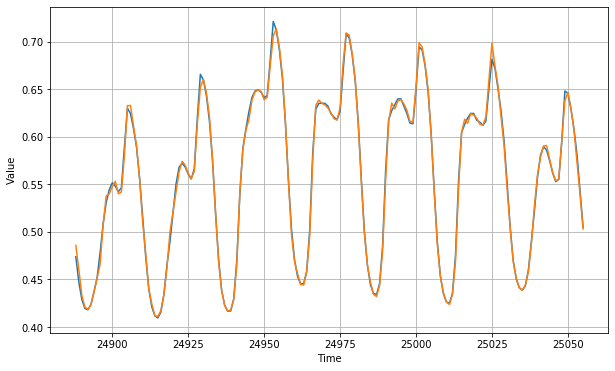

In [18]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end = 168)
plot_series(time_valid, cnn_forecast_128,start=0, end = 168)

In [0]:
import scipy.io as sio
sio.savemat('plot2.mat', {'truth':x_valid,'forecast':cnn_forecast_128})

In [18]:
mape = keras.metrics.mean_absolute_percentage_error(x_valid, cnn_forecast_128).numpy()
mae = keras.metrics.mean_absolute_error(x_valid, cnn_forecast_128).numpy()
mape

0.67494327

In [19]:
valid_series.tail()
jan = len(valid_series.loc[:'2006/1/31'])
mape = keras.metrics.mean_absolute_percentage_error(x_valid[:jan], cnn_forecast_128[:jan]).numpy()
mape

0.6305303

In [0]:
feb = valid_series.loc['2006/2/1':'2006/2/28']
feb = len(feb)
mape = keras.metrics.mean_absolute_percentage_error(x_valid[jan:jan+feb-1], cnn_forecast_128[jan:jan+feb-1]).numpy()


In [0]:
month =  valid_series.loc[valid_series['month']== 9]
def get_mape(series,valid, forecast):
  Month =  series['month'].unique()
  number = []
  MAPE = []
  for month in Month:
    num = len(series.loc[valid_series['month']== month])
    number.append(num)

  number = np.array(number)
  Sum  = np.cumsum(number)
  for i in range(len(number)):
    if i==0:
      mape = keras.metrics.mean_absolute_percentage_error(x_valid[:number[i]], cnn_forecast_128[:number[i]]).numpy()
    else:
      mape = keras.metrics.mean_absolute_percentage_error(x_valid[number[i-1]:Sum[i]], cnn_forecast_128[number[i-1]:Sum[i]]).numpy()
    
    MAPE.append(mape)
  
  return MAPE

In [0]:
MAPE = get_mape(valid_series, x_valid, cnn_forecast_128)

In [52]:
MAPE

[0.6305303,
 0.6706752,
 0.6829241,
 0.69515884,
 0.6847523,
 0.69678473,
 0.6907678,
 0.6917859,
 0.6916996,
 0.7013005,
 0.6907325,
 0.67889005]

In [31]:
valid_

year            2006.000000
month              1.000000
day               31.000000
weekday            3.000000
hour              24.000000
demand         13448.000000
temperature       31.000000
load               0.486858
Name: 2006/1/31, dtype: float64